In [1]:
%matplotlib inline
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import os
import itertools
from tqdm import *
from tqdm import tqdm_notebook as tqdm
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import clear_output

from io import StringIO
import re

import pickle
import os

from multiprocessing import Pool 
from itertools import product
import sys
from functools import partial



# Step 1: Load Data Set

In [2]:
fileNames = []
for file in os.listdir("data/train_1"):
    if file.endswith(".jpg"):
        fileNames.append(file)
# fileNamesDF = pd.DataFrame(fileNames)

In [3]:
#only take certain artist so that the probabilities aren't basically all false when doing the tupples
minNumPaintingsPerArtist = 55

# #for each artist, only take n of their paintings
numPaintingsPerAuthor = 100


trainInfo = pd.read_csv('data/train_info.csv')
trainInfo = trainInfo[trainInfo['filename'].isin(fileNames)]

mostPopularArtists = trainInfo['artist'].value_counts()[trainInfo['artist'].value_counts() > minNumPaintingsPerArtist]
# print(mostPopularArtists.head())
# fileNamesDFAll = trainInfo[trainInfo['artist'].isin(mostPopularArtists.index)]
# print(fileNamesDFAll.head())

fileNamesDF = pd.DataFrame()
moreInfo = pd.DataFrame()
for artist in tqdm(mostPopularArtists.index):
    fileNamesDF = fileNamesDF.append(trainInfo[trainInfo['artist'] == artist][:numPaintingsPerAuthor])
    
fileNamesDF.set_index('filename', inplace=True)

In [4]:
# Load the all_data_info for the dataset we are using
allInfo = pd.read_csv('data/all_data_info.csv')
allInfo.set_index('new_filename', inplace=True)

allInfo = allInfo[allInfo.index.isin(fileNamesDF.index)]


featuresDF = pd.DataFrame(index=allInfo.index)
featuresDF['pixelsx'] = allInfo['pixelsx']
featuresDF['pixelsy'] = allInfo['pixelsy']
featuresDF['style'] = allInfo['style']
featuresDF['genre'] = fileNamesDF['genre']


# featuresDF['features'] = pd.Series()

In [5]:
allInfo

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train
new_filename,,,,,,,,,,,
15075.jpg,Albrecht Durer,NaN,sketch and study,2536.0,2929.0,621267.0,wikiart,Northern Renaissance,Study of a body of Christ,train_and_test,True
18039.jpg,Albrecht Durer,1506,religious painting,2352.0,3129.0,1046324.0,wikiart,Northern Renaissance,Madonna with the Siskin,train_and_test,True
1053.jpg,Albrecht Durer,NaN,design,2536.0,2836.0,725632.0,wikiart,Northern Renaissance,Wappen Pirckheimer,train_and_test,True
1458.jpg,Albrecht Durer,NaN,miniature,2394.0,3000.0,693310.0,wikiart,Northern Renaissance,Draft for a book sign lion,train_and_test,True
18076.jpg,Odilon Redon,NaN,flower painting,2232.0,3198.0,3950198.0,wikiart,Realism,The Red Poppy,train_and_test,True
13849.jpg,Albrecht Durer,NaN,portrait,2360.0,3000.0,757619.0,wikiart,Northern Renaissance,Portrait of a Woman,train_and_test,True
1805.jpg,Albrecht Durer,NaN,portrait,2220.0,3000.0,830408.0,wikiart,Northern Renaissance,Portrait of Conrat Verkell,train_and_test,True
19349.jpg,Odilon Redon,1900,symbolic painting,2536.0,2602.0,497502.0,wikiart,Symbolism,Silence,train_and_test,True
10199.jpg,Albrecht Durer,NaN,religious painting,2187.0,3000.0,850580.0,wikipedia,Northern Renaissance,Christ on the Mount of Olives,train_and_test,True


In [8]:
def normalizeSeries(series, maxNum):
    series = series/maxNum
    return series

In [9]:
def featurizeImage(filename):
    # Extract the features from the actual image
    jpgfile = Image.open("data/train_1/" + filename)
#     print(jpgfile)
    
    bands = jpgfile.getbands()
    if bands[0] == 'L':
        # grayscale image
        imageDF = pd.DataFrame(list(jpgfile.getdata()),columns=['grayscale'])
        imageDF['red'] = 0
        imageDF['green'] = 0
        imageDF['blue'] = 0
        imageDF['alpha'] = 0
#         return imageDF
#         imageDF['grayscale'] = normalizeSeries(imageDF['grayscale',])
    elif len(bands) == 4:
        #get red, green and blue chanels 
        imageDF = pd.DataFrame(list(jpgfile.getdata()),columns=['red','green','blue','alpha'])
        imageDF['red'] = normalizeSeries(imageDF['red'],255)
        imageDF['green'] = normalizeSeries(imageDF['green'],255)
        imageDF['blue'] = normalizeSeries(imageDF['blue'],255)  
        imageDF['alpha'] = normalizeSeries(imageDF['alpha'],255) 
        imageDF['grayscale'] = 0 
    elif len(bands) == 3:
        #get red, green and blue chanels 
        imageDF = pd.DataFrame(list(jpgfile.getdata()),columns=['red','green','blue'])
        imageDF['red'] = normalizeSeries(imageDF['red'],255)
        imageDF['green'] = normalizeSeries(imageDF['green'],255)
        imageDF['blue'] = normalizeSeries(imageDF['blue'],255)  
        imageDF['alpha'] = 0  
        imageDF['grayscale'] = 0 
    else:
        imageDF = pd.DataFrame(list(jpgfile.getdata()))
        print(bands)
        return imageDF.mean(), bands
    
    
    
    return imageDF.mean()

In [10]:
def pickleDF(fileName,dataFrame,numSplits):
    print(numSplits)
    dfArray = np.array_split(dataFrame, numSplits)
    for i, df in enumerate(dfArray):
        df.to_pickle(fileName+"-"+str(i))

In [11]:
def getImgData(dataFrame,baseName):
    sys.stdout.flush()
#     index = 0
#     while os.path.exists(baseName+"-"+str(index)):
#         index = index + 1
    
    newFileName = baseName + ".pckl"
    print(newFileName)
    sys.stdout.flush()
#     featureSeries = []
    reds = []
    greens = []
    blues = []
    alphas = []
    grayscales = []
    for row in tqdm(list(dataFrame.index), leave=False): 
        imageFeatures = featurizeImage(row)
        reds.append(imageFeatures[0])
        greens.append(imageFeatures[1])
        blues.append(imageFeatures[2])
        alphas.append(imageFeatures[3])
        grayscales.append(imageFeatures[4])

        sys.stdout.flush()
    
#     print(featureSeries)
    dataFrame['red'] = reds
    dataFrame['green'] = greens
    dataFrame['blue'] = blues
    dataFrame['alpha'] = alphas
    dataFrame['grayscale'] = grayscales


#     print(dataFrame['features'])
    dataFrame.to_pickle(newFileName)
    return dataFrame

In [12]:
def concatFrames(dataFrames):
    return pd.concat(dataFrames)

In [13]:
def loadImagesFromPickles(fileNames):
    
    dataFrames = []
    for fileName in fileNames:
        dataFrames.append(pd.read_pickle(fileName))

    return concatFrames(dataFrames)

In [16]:
baseFileName = 'trainImgsAllcolorBands-NewFeaturesZeroes'

In [ ]:
splitFeaturesData = np.array_split(featuresDF,10)
print(len(splitFeaturesData))
pool = Pool()
inputData = [[splitFeaturesData[i], baseFileName+"-"+str(i)] for i in range(len(splitFeaturesData))]
pool.starmap(getImgData, inputData)
pool.close() 
results = pool.join()

In [ ]:
print(results)

# Models

In [29]:
def computeStats(truth,predictions):
    
    accuracy = (predictions == truth).sum()/len(predictions == truth)
    
    possibleArtists = truth.unique()
    artistTPR = []
    for j in possibleArtists:
        truePositive = np.sum([predictions[i] == j and truth[i] == j for i in range(len(truth))])
        trueNeg = np.sum([predictions[i] != j and truth[i] != j for i in range(len(truth))])
        falsePos = np.sum([predictions[i] == j and truth[i] != j for i in range(len(truth))])
        falseNeg = np.sum([predictions[i] != j and truth[i] == j for i in range(len(truth))])
        
        artistTPR.append(truePositive/(truePositive+falseNeg))
#         goodPredictions = [predictions] == trues[i] for i in range(len(predictions))]
        
    return accuracy, artistTPR

In [30]:
pickleLoaded = loadImagesFromPickles([baseFileName+"-"+str(i)+".pckl" for i in range(10)])

In [31]:
uniqueLabels = pd.DataFrame(allInfo.loc[pickleLoaded.index]['artist'].unique(),columns=['artist'])
uniqueStyles = pd.DataFrame(pickleLoaded['style'].unique(),columns=['style'])
uniqueGenre = pd.DataFrame(pickleLoaded['genre'].unique(),columns=['genre'])

In [32]:
pickleLoaded['style'] = pickleLoaded['style'].apply(lambda x: uniqueStyles[uniqueStyles['style'] == x].index.values[0])
pickleLoaded['genre'] = pickleLoaded['genre'].apply(lambda x: uniqueGenre[uniqueGenre['genre'] == x].index.values[0])

In [33]:
allLabels = allInfo.loc[pickleLoaded.index]['artist']

In [34]:
nTrainFraction = 0.6
featuresTrain = pickleLoaded.sample(frac=nTrainFraction)
featuresDev = pickleLoaded.drop(featuresTrain.index)

labelsTrain = allLabels.loc[featuresTrain.index]
labelsTrainValue = labelsTrain.apply(lambda x: uniqueLabels[uniqueLabels['artist'] == x].index.values[0])

labelsDev = allLabels.loc[featuresDev.index]
labelsDevValue = labelsDev.apply(lambda x: uniqueLabels[uniqueLabels['artist'] == x].index.values[0])

accuracies = []

artistStats = pd.DataFrame(uniqueLabels.loc[labelsDevValue.unique()])
artistStats['number'] = labelsDevValue.value_counts()

for numEstimator in trange(1,100):
    classifier = RandomForestClassifier(n_estimators=numEstimator)
    classifier.fit(featuresTrain,labelsTrainValue)
    predictions = classifier.predict(featuresDev)

    accuracy, artistTPR = computeStats(labelsDevValue,predictions)

    accuracies.append(accuracy)

    artistStats['tpr-'+str(numEstimator)] = pd.Series(artistTPR)
    
#     print(artistResults)

100%|██████████| 99/99 [00:13<00:00,  7.20it/s]


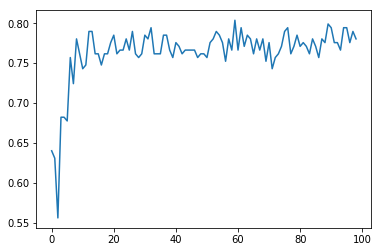

In [35]:
pd.Series(accuracies).plot()

In [67]:
sameAuthor = [False for v in itertools.product(featuresDev.index,featuresDev.index)]
print(len(sameAuthor))
# print(featuresDev.index)
for i, v in tqdm(enumerate(itertools.product(featuresDev.values,featuresDev.values)),total= len(sameAuthor)):
    predictions = classifier.predict(v)
#     print(predictions)
    
    if predictions[0] == predictions[1]:
        sameAuthor[i] = True
    else:
        sameAuthor[i] = False

45796


In [76]:
pd.Series(sameAuthor).count() - pd.Series(sameAuthor).sum()

40428

In [75]:
pd.Series(sameAuthor).sum()

5368